In [2]:
# 필요한 라이브러리 설치

# numpy: 데이터 분석 및 수학 계산용
# pandas: 데이터프레임 작업용
# matplotlib: 데이터 시각화용
# datetime: 날짜 및 시간 처리용 (Python 표준 라이브러리)
# 위 라이브러리 설치 실행 명령어어
# %pip install numpy pandas matplotlib datetime

# 설치한 라이브러리 이외로 누락이 있을수 있습니다.

In [3]:
import numpy as np 
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
# jupyter Notebook에서 사용하는 매직 명령어입니다. 이 명령어는 그래프를 생성한 후 해당 그래프를 노트북의 셀 내부에 즉시 렌더링(표시)하도록 설정
import os


In [4]:
dataset = pd.read_csv("IOT-temp.csv")
display(dataset.head())
print("Shape of Dataset : ", dataset.shape)

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In


Shape of Dataset :  (97606, 5)


열의 상태를 확인해 보겠습니다.

In [5]:
dataset.dtypes

id            object
room_id/id    object
noted_date    object
temp           int64
out/in        object
dtype: object

In [6]:
dataset["room_id/id"].nunique()


1

1. Since the unique values of column *room_id/id* is 1, we can drop this column alongwith the *id* column.
2. Also column name 'out/in' isn't a good column name, let's rename it to 'Out_In'.
3. We can also see the presence of some duplicate records. We need to handle those as well.

In [7]:
dataset.drop(columns=['room_id/id','id'], inplace=True)

In [8]:
dataset.rename(columns={'out/in':"Out_In"}, inplace=True)

In [9]:
print("Before duplicate treatment : ", dataset.shape)
dataset.drop_duplicates(subset=['noted_date','Out_In','temp'], keep='first',inplace=True)
print("After duplicate treatment : ", dataset.shape)

Before duplicate treatment :  (97606, 3)
After duplicate treatment :  (37268, 3)


Let's check the timespan in which the data was recorded.

In [10]:
print("Data recorded from {} to {}".format(min(dataset.noted_date), max(dataset.noted_date)))
print("Minimum Temperature : {} degrees \nMaximum Temperature : {} degrees".format(min(dataset.temp), max(dataset.temp)))

Data recorded from 01-11-2018 00:06 to 31-10-2018 23:57
Minimum Temperature : 21 degrees 
Maximum Temperature : 51 degrees


Good! We have about an year's worth of data recorded from 1st November,2018 to 31st October,2018.
Let's have a look at the frequency of the sensor in a day i.e. how many times in a day the sensor measures the temperature.

Let's create the column for the _date_ first, since the *noted_date* has both DD/MM/YYY and the HH:MM components together.

We can use the _noted_date_ column to create a lot of columns basis date and time!

Let's go!

In [11]:
dataset['date'] = dataset['noted_date'].apply(lambda x: dt.datetime.strptime(x, '%d-%m-%Y %H:%M').date())


dataset['day'] = dataset['noted_date'].apply(lambda x: dt.datetime.strptime(x, '%d-%m-%Y %H:%M').day)
dataset['month'] = dataset['noted_date'].apply(lambda x: dt.datetime.strptime(x, '%d-%m-%Y %H:%M').month)
dataset['year'] = dataset['noted_date'].apply(lambda x: dt.datetime.strptime(x, '%d-%m-%Y %H:%M').year)

dataset['hour'] = dataset['noted_date'].apply(lambda x: dt.datetime.strptime(x, '%d-%m-%Y %H:%M').hour)
dataset['minute'] = dataset['noted_date'].apply(lambda x: dt.datetime.strptime(x, '%d-%m-%Y %H:%M').minute)
dataset.drop(columns = ['noted_date'], inplace = True)
dataset.head()

,temp,Out_In,date,day,month,year,hour,minute
0,29,In,2018-12-08,8,12,2018,9,30
2,41,Out,2018-12-08,8,12,2018,9,29
4,31,In,2018-12-08,8,12,2018,9,29
6,29,In,2018-12-08,8,12,2018,9,28
8,29,In,2018-12-08,8,12,2018,9,26


In [12]:
grouped_by_date = pd.DataFrame(dataset.groupby('date')['minute'].count())
min_freq = grouped_by_date.min()
max_freq = grouped_by_date.max()
grouped_by_date.reset_index(inplace=True)
print(type(grouped_by_date))
display(grouped_by_date.head())

<class 'pandas.core.frame.DataFrame'>


,date,minute
0,2018-07-28,30
1,2018-07-29,15
2,2018-07-31,24
3,2018-08-02,6
4,2018-08-10,302


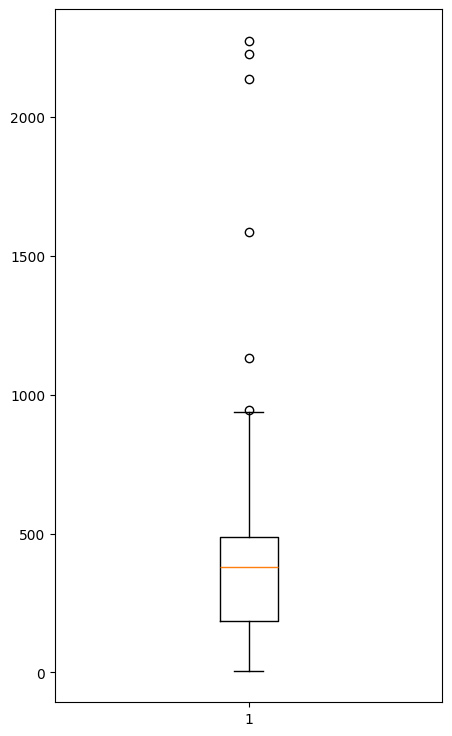

In [13]:
grouped_by_date.rename(columns = {"date": "date",
                                  "minute":"frequency"}, inplace = True)
grouped_by_date.head()
plt.figure(figsize=(5,9))
_ = plt.boxplot(grouped_by_date.frequency)

Let's see how the Inside and Outside temperature varies across time. Let's also create a Inside-Outside flag to be used later for plotting purposes.

In [14]:
def ioflag(x):
    if x=='In':
        return 1
    else:
        return 0
dataset['IO_Flag'] = dataset['Out_In'].apply(lambda x: ioflag(x))
dataset.head()

,temp,Out_In,date,day,month,year,hour,minute,IO_Flag
0,29,In,2018-12-08,8,12,2018,9,30,1
2,41,Out,2018-12-08,8,12,2018,9,29,0
4,31,In,2018-12-08,8,12,2018,9,29,1
6,29,In,2018-12-08,8,12,2018,9,28,1
8,29,In,2018-12-08,8,12,2018,9,26,1


In [15]:
print("Number of records from dataset for Out : ", dataset[dataset['Out_In'] == 'Out'].shape[0]
,"\nNumber of records from dataset for In :  ",dataset[dataset['Out_In'] == 'In'].shape[0])
print("% Distribution for Outside/Inside is 73:28 ")#, 100*(dataset[dataset['Out_In'] == 'Out'].shape[0]/dataset.shape[0]))

Number of records from dataset for Out :  27326 
Number of records from dataset for In :   9942
% Distribution for Outside/Inside is 73:28 


The sensor has recorded Outside temperatures more than the inside. Let's count the number of Outside and Inside temperatures in a day, see if this is a daily behaviour or some dicrepancy.

In [16]:
daily_measurement_frequency = pd.DataFrame(dataset.groupby(['date','Out_In'])['temp'].mean())
daily_measurement_frequency.reset_index(inplace=True)
daily_measurement_frequency.rename(columns={'temp':'mean_temperature'}, inplace = True)
daily_measurement_frequency.head()

,date,Out_In,mean_temperature
0,2018-07-28,In,31.000000
1,2018-07-28,Out,31.695652
2,2018-07-29,In,32.500000
3,2018-07-29,Out,31.363636
4,2018-07-31,In,30.750000


In [17]:
print(type(daily_measurement_frequency))

<class 'pandas.core.frame.DataFrame'>


In [18]:
daily_measurement_frequency[daily_measurement_frequency['mean_temperature'] <= 1000 ].head(20)

,date,Out_In,mean_temperature
0,2018-07-28,In,31.000000
1,2018-07-28,Out,31.695652
2,2018-07-29,In,32.500000
3,2018-07-29,Out,31.363636
4,2018-07-31,In,30.750000
5,2018-07-31,Out,32.400000
6,2018-08-02,Out,32.500000
7,2018-08-10,In,28.606250
8,2018-08-10,Out,31.211268
9,2018-08-11,In,32.677419


### Mean Temperature
Let's plot daily mean temperature basis Inside and Outside

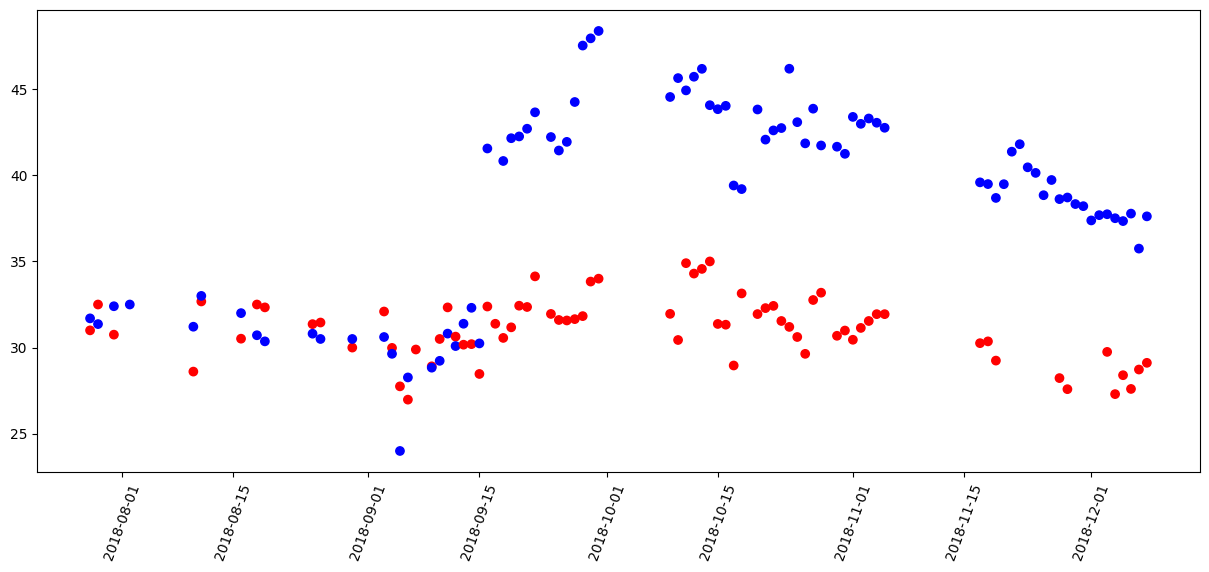

In [19]:
colors = {'In':'red', 'Out':'blue'}
plt.figure(figsize=(15,6))
plt.xticks(rotation=70)
plt.scatter(daily_measurement_frequency['date'],
        daily_measurement_frequency['mean_temperature'],
        c=daily_measurement_frequency['Out_In'].apply(lambda x : colors[x]))
plt.show()

In [20]:
daily_measurement_variety = pd.DataFrame(dataset[['date','Out_In']].groupby(['date'])['Out_In'].nunique())
daily_measurement_variety.reset_index(inplace=True)
daily_measurement_variety.rename(columns = {'Out_In':'Measurements'}, inplace=True)
daily_measurement_variety.head()

,date,Measurements
0,2018-07-28,2
1,2018-07-29,2
2,2018-07-31,2
3,2018-08-02,1
4,2018-08-10,2


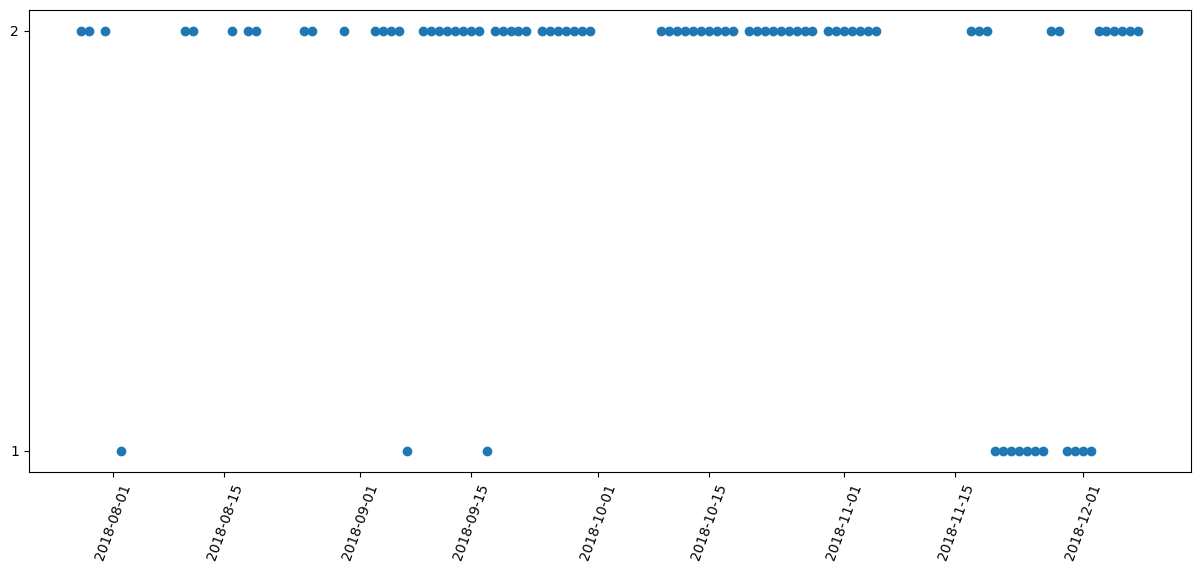

In [21]:
plt.figure(figsize=(15,6))
plt.xticks( rotation=70)
plt.yticks(np.arange(0,5,1.0))
plt.scatter(daily_measurement_variety['date'],daily_measurement_variety['Measurements'] )

In [22]:
print(daily_measurement_variety['Measurements'].value_counts())

Measurements
2    72
1    14
Name: count, dtype: int64


In [23]:
dataset.date.nunique()

86

In [24]:
dataset = dataset.merge(daily_measurement_variety, left_on='date', right_on='date')

In [25]:
dataset.head()

,temp,Out_In,date,day,month,year,hour,minute,IO_Flag,Measurements
0,29,In,2018-12-08,8,12,2018,9,30,1,2
1,41,Out,2018-12-08,8,12,2018,9,29,0,2
2,31,In,2018-12-08,8,12,2018,9,29,1,2
3,29,In,2018-12-08,8,12,2018,9,28,1,2
4,29,In,2018-12-08,8,12,2018,9,26,1,2


In [26]:
dataset.groupby(['Measurements','Out_In']).count()

temp   date    day  month   year   hour  minute  IO_Flag
Measurements Out_In                                                           
1            In        302    302    302    302    302    302     302      302
             Out      3846   3846   3846   3846   3846   3846    3846     3846
2            In       9640   9640   9640   9640   9640   9640    9640     9640
             Out     23480  23480  23480  23480  23480  23480   23480    23480

In [27]:
dataset.groupby(['Measurements','Out_In'])['date'].nunique()

Measurements  Out_In
1             In         2
              Out       12
2             In        72
              Out       72
Name: date, dtype: int64

In [28]:
dataset.shape

(37268, 10)

In [29]:
monthly_split = pd.DataFrame(dataset.groupby(['month'])['temp'].mean())
monthly_split.reset_index(inplace=True)
monthly_split.rename(columns={'temp':'mean_temp'})
monthly_split.head()

,month,temp
0,7,31.768116
1,8,30.732843
2,9,33.588698
3,10,39.435035
4,11,39.151133


In [30]:
display(monthly_split.sort_values(by=['temp'], ascending=False))
display(monthly_split.sort_values(by=['temp'], ascending=True))


,month,temp
3,10,39.435035
4,11,39.151133
5,12,34.435781
2,9,33.588698
0,7,31.768116
1,8,30.732843


,month,temp
1,8,30.732843
0,7,31.768116
2,9,33.588698
5,12,34.435781
4,11,39.151133
3,10,39.435035


In [31]:
monthly_type_split = pd.DataFrame(dataset.groupby(['month','Out_In',])['temp'].mean())
monthly_type_split.reset_index(inplace=True)
monthly_type_split.rename(columns={'temp':'mean_temp'})
monthly_type_split.head()

,month,Out_In,temp
0,7,In,31.333333
1,7,Out,31.888889
2,8,In,30.088235
3,8,Out,31.193277
4,9,In,30.761445


In [32]:
display(monthly_type_split[monthly_type_split['Out_In']=='In'].sort_values(by=['temp'], ascending=True))
display(monthly_type_split[monthly_type_split['Out_In']=='Out'].sort_values(by=['temp'], ascending=True))

display(monthly_type_split[monthly_type_split['Out_In']=='In'].sort_values(by=['temp'], ascending=False))
display(monthly_type_split[monthly_type_split['Out_In']=='Out'].sort_values(by=['temp'], ascending=False))

,month,Out_In,temp
10,12,In,28.462664
2,8,In,30.088235
8,11,In,30.606574
4,9,In,30.761445
0,7,In,31.333333
6,10,In,31.560298


,month,Out_In,temp
3,8,Out,31.193277
1,7,Out,31.888889
5,9,Out,34.964339
11,12,Out,37.348348
9,11,Out,40.498508
7,10,Out,41.885607


,month,Out_In,temp
6,10,In,31.560298
0,7,In,31.333333
4,9,In,30.761445
8,11,In,30.606574
2,8,In,30.088235
10,12,In,28.462664


,month,Out_In,temp
7,10,Out,41.885607
9,11,Out,40.498508
11,12,Out,37.348348
5,9,Out,34.964339
1,7,Out,31.888889
3,8,Out,31.193277


---
## My Observations so far...

### Observations regarding inconsistencies in data
1. Even though the max and min date in the dataset give an impression that the sensor carried out measurements for an year, distinct number of days is only 86 days.
2. After de-duplication of records, the number of records is 37,268. Out of which, the distribution of outside vs inside temp ratio is 73:27, i.e. 73% of records show a temperature measurement of the 'Outside'.
3. Going deeper, we can see that out of 86 days, there were 14 days when only a single type of temperature (either 'In' or 'Out') measurement was taken and during the remaining 72 days both kind of temperature measurement was taken.
4. Further, out of the 14 days where only a single type of temperature was measured, 2 days recorded 'Only Inside' temperature and 12 days recorded 'Only Outside' temperature.
5. Out of our 37,368 records, there are 4,148 records where a single type of temperature was recorded and 33,120 records measured both types of temperature.
6. Further, out of 4,148 records with single type of temperature, 302 are for 'Inside' and 3,846 are for 'Outside'. Also, out of  33,120 records with both type of temperatures, 9,640 are for 'Inside' and 23,480 are for 'Outside'.

### General contextual observations
1. Maximum temperature is 51 degrees and minimum temperature is 21 degrees.
2. Month with the minimum mean temperature is August and the maximum temperature is October.
3. Month with the minimum Inside Temperature is December and maximum Inside Temperature is October.
4. Month with the minimum Outside Temperature is August and maximum Outside Temperature is October.
